In [1]:
!pip install pm4py
!pip install optuna

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.8 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=ce4642edc788d75c2e635b12789e2890aeca0f08b5bbf6feb9d91cff06e01d86
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00


In [ ]:
log_url = "https://data.4tu.nl/datasets/6a0a26d2-82d0-4018-b1cd-89afb0e8627f"

In [2]:
import pm4py
import optuna
import pandas as pd
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristic_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.check_soundness import check_easy_soundness_net_in_fin_marking
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.statistics.traces.generic.pandas import case_statistics

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


**Choose dataset**

In [3]:
# Domestic declarations log
log = pm4py.read_xes('DomesticDeclarations.xes')

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [21]:
# Italian helpdesk log
data = pd.read_csv('finale.csv')
data.rename(columns={
    'Case ID': 'case:concept:name',
    'Activity': 'concept:name',
    'Complete Timestamp': 'time:timestamp'
}, inplace=True)

# Convert the timestamp column to datetime format
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])

# Ensure the activity names are treated as strings
data['concept:name'] = data['concept:name'].astype(str)
log = data

In [ ]:
log

[{'attributes': {'concept:name': 'Case 1'}, 'events': [{'concept:name': 'Assign seriousness', 'Resource': 'Value 1', 'time:timestamp': Timestamp('2012-10-09 14:50:17'), 'Variant': 'Variant 12', 'Variant index': 12, 'Variant.1': 'Variant 12', 'seriousness': 'Value 1', 'customer': 'Value 1', 'product': 'Value 1', 'responsible_section': 'Value 1', 'seriousness_2': 'Value 1', 'service_level': 'Value 1', 'service_type': 'Value 1', 'support_section': 'Value 1', 'workgroup': 'Value 1'}, '..', {'concept:name': 'Closed', 'Resource': 'Value 3', 'time:timestamp': Timestamp('2012-11-09 12:54:39'), 'Variant': 'Variant 12', 'Variant index': 12, 'Variant.1': 'Variant 12', 'seriousness': 'Value 1', 'customer': 'Value 1', 'product': 'Value 1', 'responsible_section': 'Value 1', 'seriousness_2': 'Value 1', 'service_level': 'Value 2', 'service_type': 'Value 1', 'support_section': 'Value 1', 'workgroup': 'Value 1'}]}, '....', {'attributes': {'concept:name': 'Case 4580'}, 'events': [{'concept:name': 'Take i

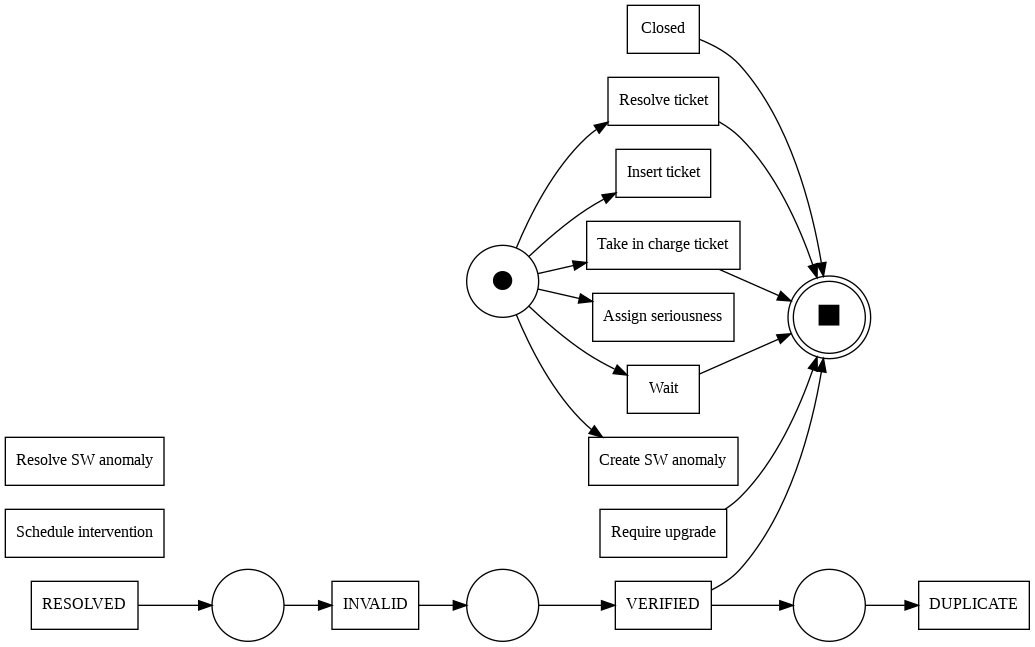

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

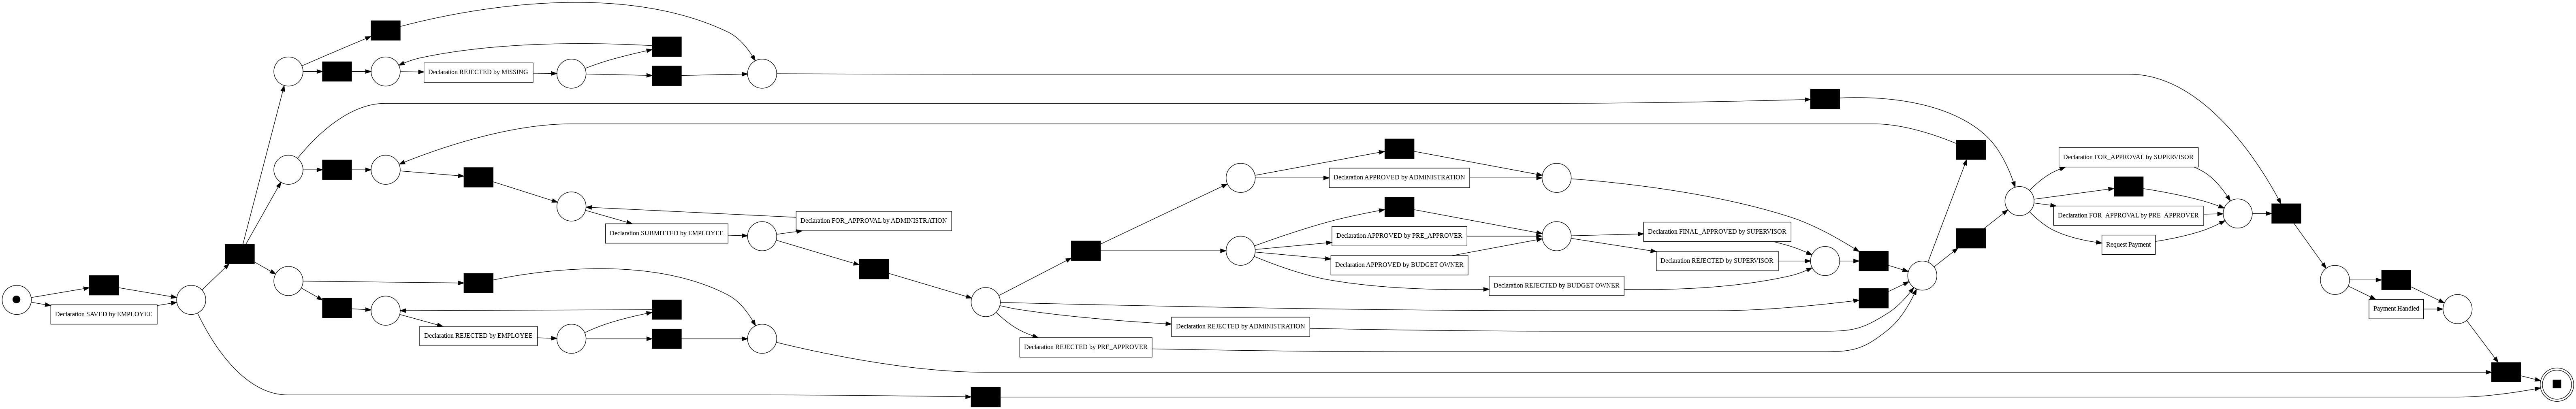

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

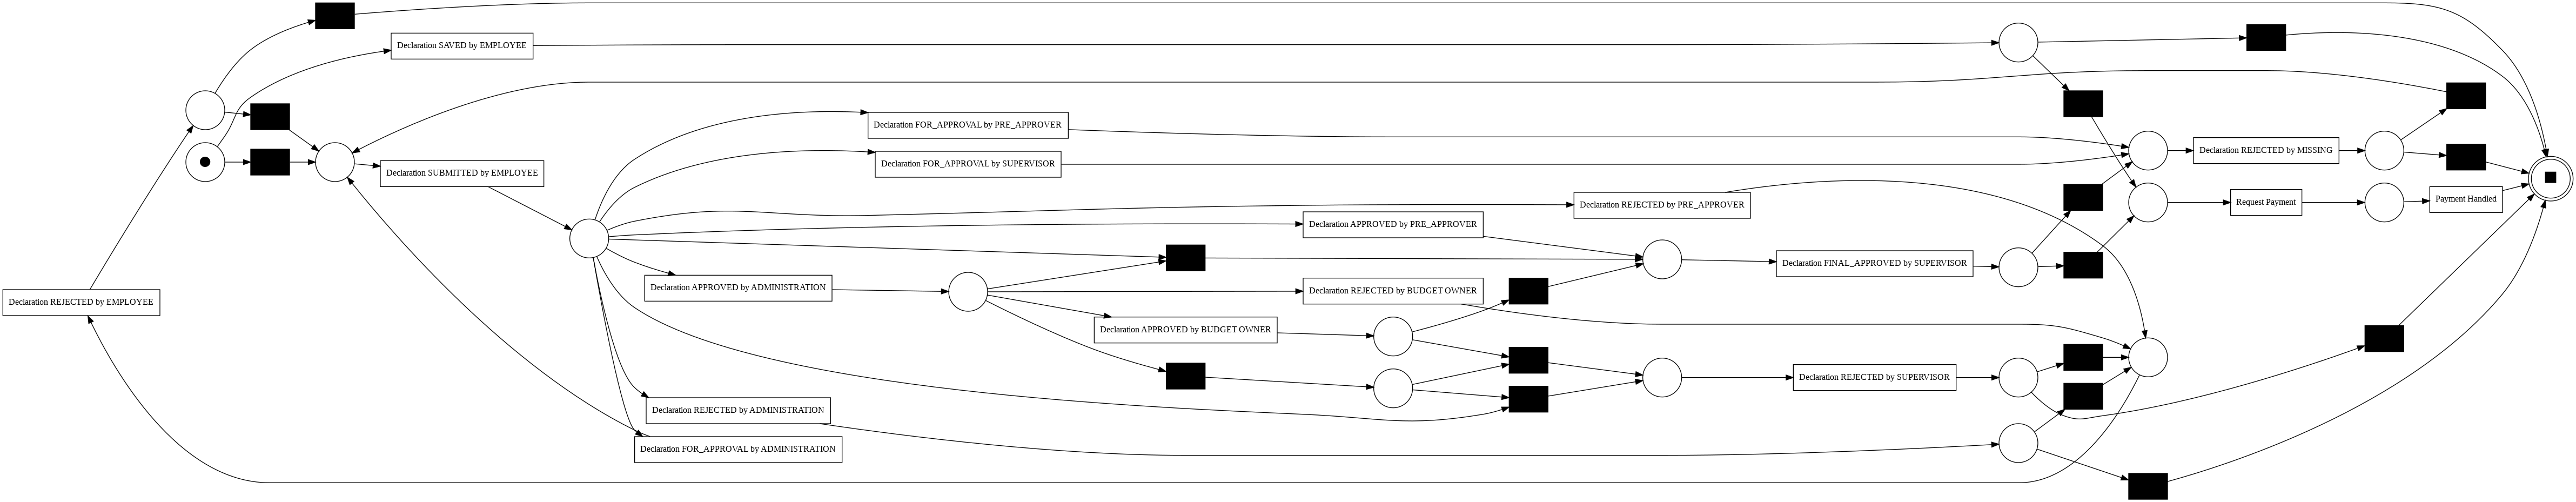

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

In [22]:
"""
Functions for evaluation
"""

def evaluate_fitness(net, initial_marking, final_marking, log):
    # Check if the produced net has sound structure or not
    is_sound = check_easy_soundness_net_in_fin_marking(net, initial_marking, final_marking)

    if is_sound:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.ALIGNMENT_BASED
        )
    else:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.TOKEN_BASED
        )

    return fitness_results["log_fitness"]

def evaluate_simplicity(net, weight_places=1, weight_transitions=2, weight_arcs=1):
    """
    Evaluates simplicity of a Petri net based on its structural complexity.

    Parameters:
        net: The Petri net object.
        weight_places: Weight for places in the simplicity calculation.
        weight_transitions: Weight for transitions in the simplicity calculation.
        weight_arcs: Weight for arcs in the simplicity calculation.

    Returns:
        A simplicity score (higher is simpler).
    """
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)

    # Weighted simplicity calculation
    complexity = (
        weight_places * num_places +
        weight_transitions * num_transitions +
        weight_arcs * num_arcs
    )
    simplicity = 1 / (complexity + 1)  # Avoid division by zero
    return simplicity

def evaluate_generalization(net, initial_marking, final_marking, log):
    # Trace coverage
    replay_results = token_replay.apply(log, net, initial_marking, final_marking)
    fully_replayed = sum(1 for res in replay_results if res['trace_is_fit'])
    trace_coverage = fully_replayed / len(replay_results) if replay_results else 0

    # Model complexity vs. log variability
    unique_traces = case_statistics.get_variant_statistics(log)
    num_unique_traces = len(unique_traces)
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)
    model_complexity = num_places + num_transitions + num_arcs
    variability_ratio = num_unique_traces / (model_complexity + 1)

    # Weighted generalization score
    generalization = (trace_coverage * 0.6) + (variability_ratio * 0.4)
    return generalization

In [16]:
def apply_alpha(log):
    net, initial_marking, final_marking = alpha_miner.apply(log)
    return net, initial_marking, final_marking

def apply_heuristic(log, parameters):
    net, initial_marking, final_marking = heuristic_miner.apply(log, parameters=parameters)
    return net, initial_marking, final_marking

def apply_inductive(log, noise_threshold=0.0):
    parameters = {"noise_threshold": noise_threshold}
    process_tree = inductive_miner.apply(log, parameters=parameters)

    # Convert the Process Tree to a Petri net
    net, initial_marking, final_marking = pt_converter.apply(process_tree)
    return net, initial_marking, final_marking

In [23]:
def objective(trial):
    # Select an algorithm
    algorithm = trial.suggest_categorical("algorithm", ["alpha", "heuristic", "inductive"])

    # Apply the selected algorithm
    if algorithm == "alpha":
        net, initial_marking, final_marking = apply_alpha(log)
    elif algorithm == "heuristic":
        dependency_thresh = trial.suggest_float("dependency_thresh", 0.0, 1.0)
        and_measure_thresh = trial.suggest_float("and_measure_thresh", 0.5, 1.0)
        loop_two_thresh = trial.suggest_float("loop_two_thresh", 0.0, 1.0)
        parameters = {
        "dependency_thresh": dependency_thresh,
        "and_measure_thresh": and_measure_thresh,
        "loop_two_thresh": loop_two_thresh
        }
        net, initial_marking, final_marking = apply_heuristic(log, parameters=parameters)
    elif algorithm == "inductive":
        noise_threshold = trial.suggest_float("noise_threshold", 0.0, 0.3)
        net, initial_marking, final_marking = apply_inductive(log, noise_threshold=noise_threshold)

    # Evaluate metrics
    fitness = evaluate_fitness(net, initial_marking, final_marking, log)
    simplicity = evaluate_simplicity(net)
    generalization = evaluate_generalization(net, initial_marking, final_marking, log)

    # Combine metrics (weighted sum as an example)
    combined_score = fitness * 0.6 + simplicity * 0.2 + generalization * 0.2
    return combined_score

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-12-14 22:41:51,477] A new study created in memory with name: no-name-53761a1f-a577-4d59-ba21-f61502946eed


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:41:53,403] Trial 0 finished with value: 0.7960194596809352 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7960194596809352.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:42:04,765] Trial 1 finished with value: 0.4925284782785445 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.7356215131988043, 'and_measure_thresh': 0.9223817320904778, 'loop_two_thresh': 0.49355801697389834}. Best is trial 0 with value: 0.7960194596809352.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:42:06,662] Trial 2 finished with value: 0.7960194596809352 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7960194596809352.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:42:18,903] Trial 3 finished with value: 0.5274405006841263 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.7307932716388177, 'and_measure_thresh': 0.6082309490093877, 'loop_two_thresh': 0.11777291439481508}. Best is trial 0 with value: 0.7960194596809352.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:42:32,957] Trial 4 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2778156809452667}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:42:42,985] Trial 5 finished with value: 0.492780283917682 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.18668456327005767, 'and_measure_thresh': 0.6888167585926802, 'loop_two_thresh': 0.7141559593180106}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:42:57,974] Trial 6 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.21114466835765633}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:43:06,801] Trial 7 finished with value: 0.5036538648458744 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.8340803921988196, 'and_measure_thresh': 0.8912829102556041, 'loop_two_thresh': 0.062095602683352236}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:43:21,572] Trial 8 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.17896015197804419}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:43:35,931] Trial 9 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.18519818124074058}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:43:49,990] Trial 10 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.29755384347548486}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:44:05,260] Trial 11 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2854521439818984}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:44:20,570] Trial 12 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2119524156751466}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:44:34,916] Trial 13 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.024702855425772274}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:44:49,230] Trial 14 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.24431197577201524}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:45:03,784] Trial 15 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.10363626567258594}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:45:05,643] Trial 16 finished with value: 0.7960194596809352 and parameters: {'algorithm': 'alpha'}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:45:19,667] Trial 17 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1261737367113598}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:45:34,103] Trial 18 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.23961297813940355}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:45:35,671] Trial 19 finished with value: 0.7960194596809352 and parameters: {'algorithm': 'alpha'}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:45:50,026] Trial 20 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2576254209392922}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:46:04,117] Trial 21 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.17345154485329237}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:46:18,446] Trial 22 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.20950590429482746}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:46:32,551] Trial 23 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.14095686649316855}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:46:46,622] Trial 24 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.08640922799285909}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:47:01,084] Trial 25 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.18001426739556464}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:47:15,304] Trial 26 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.21707456211601753}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:47:29,455] Trial 27 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.26796109424887893}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:47:31,376] Trial 28 finished with value: 0.7960194596809352 and parameters: {'algorithm': 'alpha'}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:48:42,144] Trial 29 finished with value: 0.48720420731485464 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.06282619893382824, 'and_measure_thresh': 0.5032749539710715, 'loop_two_thresh': 0.9769187671535989}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:48:44,380] Trial 30 finished with value: 0.7960194596809352 and parameters: {'algorithm': 'alpha'}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:48:58,651] Trial 31 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.17904383994455747}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:49:13,296] Trial 32 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.16813481031985994}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:49:27,498] Trial 33 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.20763434573248596}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:49:41,592] Trial 34 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.23003764839989388}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:49:51,167] Trial 35 finished with value: 0.49469131704402564 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.3720003106839291, 'and_measure_thresh': 0.804559773108236, 'loop_two_thresh': 0.41587375844127283}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:50:05,994] Trial 36 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.19069563806783038}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:50:13,295] Trial 37 finished with value: 0.6194453835393179 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.44126099041649613, 'and_measure_thresh': 0.9649707195926729, 'loop_two_thresh': 0.8645309689262217}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:50:28,014] Trial 38 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.15138838424310544}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:50:29,703] Trial 39 finished with value: 0.7960194596809352 and parameters: {'algorithm': 'alpha'}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:50:44,430] Trial 40 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.26715587180817063}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:50:58,703] Trial 41 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2996715476868071}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:51:13,306] Trial 42 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2990174968279218}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:51:28,161] Trial 43 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2760233470638642}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:51:42,791] Trial 44 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1517052300336569}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:51:52,324] Trial 45 finished with value: 0.5667774272275939 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.9852725623150033, 'and_measure_thresh': 0.7747792010736287, 'loop_two_thresh': 0.3015494974772358}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:52:06,621] Trial 46 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2854985376368881}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:52:20,800] Trial 47 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.24316467070967232}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:52:35,453] Trial 48 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1954250776631956}. Best is trial 4 with value: 0.8162568559696065.


aligning log, completed variants ::   0%|          | 0/226 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/226 [00:00<?, ?it/s]

[I 2024-12-14 22:52:49,665] Trial 49 finished with value: 0.8162568559696065 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2546183918816025}. Best is trial 4 with value: 0.8162568559696065.


Best algorithm and parameters:
{'algorithm': 'inductive', 'noise_threshold': 0.2778156809452667}


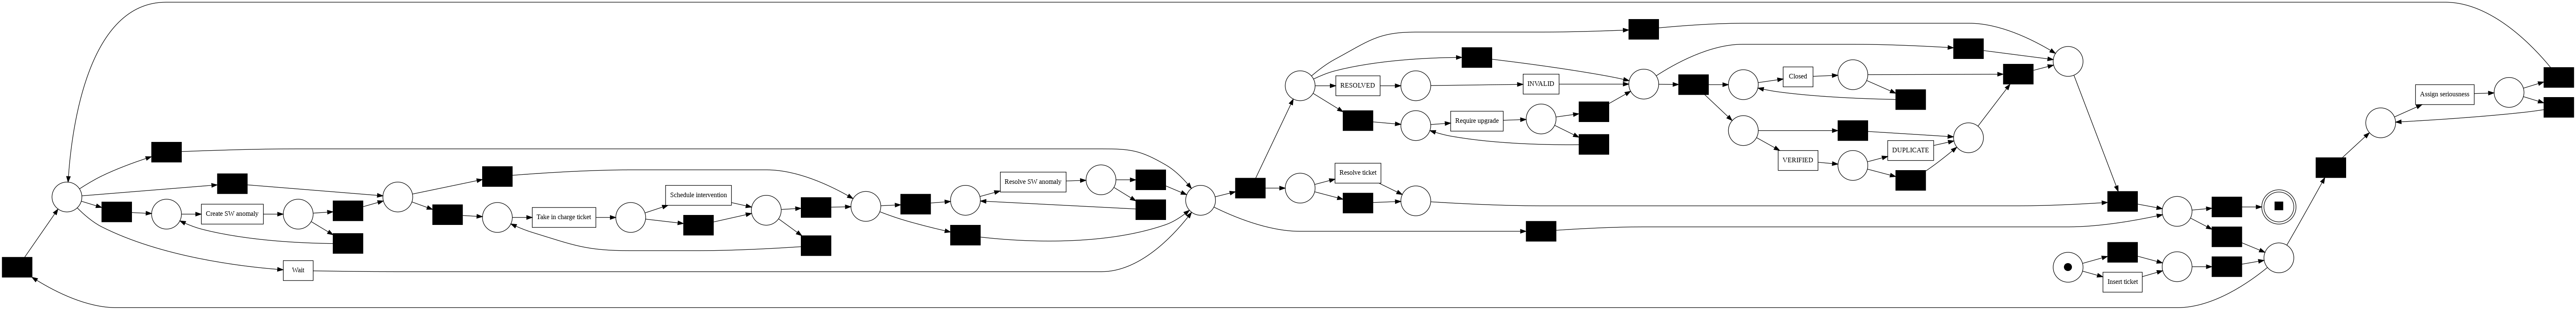

In [25]:
print("Best algorithm and parameters:")
print(study.best_params)

# Apply the best model to get the final process model
best_algorithm = study.best_params["algorithm"]
if best_algorithm == "alpha":
    final_net, final_initial_marking, final_final_marking = apply_alpha(log)
elif best_algorithm == "heuristic":
    best_dependency_thresh = study.best_params["dependency_thresh"]
    final_net, final_initial_marking, final_final_marking = apply_heuristic(log, dependency_thresh=best_dependency_thresh)
elif best_algorithm == "inductive":
    best_noise_threshold = study.best_params["noise_threshold"]
    final_net, final_initial_marking, final_final_marking = apply_inductive(log, noise_threshold=best_noise_threshold)

# Visualize the best model
gviz = pn_visualizer.apply(final_net, final_initial_marking, final_final_marking)
pn_visualizer.view(gviz)